# STA 141B Assignment 3

Due __XXXXX, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__Exercise 1__

We will compute the [PageRank](https://en.wikipedia.org/wiki/PageRank) of the articles of the [Hawaiian](https://en.wikipedia.org/wiki/Hawaiian_language) wikipedia, which is available at [haw.wikipedia.org](https://haw.wikipedia.org/wiki/Ka_papa_kinohi). Additional information of the Hawaiian wiki can be found [here](https://meta.wikimedia.org/wiki/List_of_Wikipedias). 

_Hints: If you don't speak Hawaiian, you might want to learn the wiki logic from the English wikipedia, and translate your findings. Also, caching is recommended._

__(a)__ Use the special [AllPages](https://haw.wikipedia.org/wiki/Papa_nui:AllPages) page and understand its logic to retrieve the url of all articles in the Hawaiian wikipedia. Make sure to skip redirections.

_How many articles did you find? (I found a bit more than 2541.)_

In [3]:
# a) 
import requests
import requests_cache
import lxml.html as lx
import re

In [4]:
requests_cache.install_cache("hawaii_wiki_cache")
curr_link = "https://haw.wikipedia.org/wiki/Papa_nui:AllPages"
response = requests.get(curr_link)
page = lx.fromstring(response.text)
next_page = 1
visited_links = {}
next_pages = set()
while next_page not in next_pages:
    next_pages.add(next_page)
    response = requests.get(curr_link)
    page = lx.fromstring(response.text)
    next_page = page.xpath('//*[@id="mw-content-text"]/div[2]/a[last()]/@href')[0]
    next_page = f'https://haw.wikipedia.org{next_page}'
    links = page.xpath('//*[@id="mw-content-text"]/div[3]/ul/li[not(contains(@class, "allpagesredirect"))]/a/@href')
    for link in links:
        if link.startswith('/wiki'):
            link = f'https://haw.wikipedia.org{link}'
        visited_links[link] = []
    curr_link = next_page
len(visited_links)

2629

# ANSWER
I got 2629 total links from the allpages


__(b, i)__ Write a function that scans an article given by its url and retrieves all links to other articles in the Hawaiian wikipedia. Avoid links to special pages, images or the ones that point to another website. Only count the proper article for links that point to a specific section. Use regular expressions to manage these cases. 
__(ii)__ Make sure to match redirections to their correct destiation article. To this end, find how wikipedia treats redirections and retrieve the true article. _(Help: Try searching for 'uc davis' on en.wikipedia.org')_
To this end, I used the collection or article urls obtained in (a), which I stored in a dict object to allow for fast lookups. Then, for each new found link I checked whether that link appeared in the dict. If not, It might be a re-direction and receive special attention.  
__(iii)__ Request all articles and obtain all links to other articles. 

_How many links to other articles are there? (I found 9,000-10,000.)_

In [24]:
link = 'https://haw.wikipedia.org/w/index.php?title=%27Alepa&redirect=no'
response = requests.get(link)
page = lx.fromstring(response.content)
redirects = page.xpath('//*[@id="mw-content-text"]//ul[@class="redirectText"]//a/@href')
redirects

['/wiki/%CA%BBAlepa']

In [3]:
requests_cache.install_cache("hawaii_wiki_cache")
def scan_article(urls):
    counter = 0
    article_matches = re.compile(r'^/wiki/[^:#]+$')
    for url in urls:
        response = requests.get(url)
        page = lx.fromstring(response.text)
        valid_links = page.xpath('//*[@id="mw-content-text"]//a[not(@class="mw-file-description") and contains(@href, "/wiki/") and not(@class="mw-redirect") and not(@class="extiw") and not(contains(@href, "/Wikipedia:"))]/@href')
        redirects = page.xpath('//*[@id="mw-content-text"]//a[@class="mw-redirect"]/@href')
        for link in valid_links:
            link = f'https://haw.wikipedia.org{link}'
        for redirect in redirects:
            redirect = f'https://haw.wikipedia.org{redirect}'
            if redirect in urls:
                valid_links.append(redirect)
            else:
                response = requests.get(redirect)
                new_page = lx.fromstring(response.text)
                secondary_redirect = new_page.xpath('//*[@id="mw-content-text"]//ul[@class="redirectText"]//a/@href')
                for sec_redirect in secondary_redirect:
                    valid_links.append(sec_redirect)
        for link in valid_links:
            if article_matches.match(link):
                link  = f'https://haw.wikipedia.org{link}'
                urls[url].append(link)
        counter += len(valid_links)      
            

    return counter, urls
        

In [4]:
total, returned_links = scan_article(visited_links)

In [5]:
total#hw3/hawaii_wiki_cache.sqlite

17834

# ANSWER
I got about 17800 total 

__(c)__ Compute the transition matrix (see [here](https://en.wikipedia.org/wiki/Google_matrix) and [here](https://www.amsi.org.au/teacher_modules/pdfs/Maths_delivers/Pagerank5.pdf) for step-by-step instructions). Make sure to tread dangling nodes. You may want to use: 
```
import numpy as np
from scipy.sparse import csr_matrix
```

In [6]:
import numpy as np
from scipy.sparse import csr_matrix

link_keys = list(returned_links.keys())
link_indexing = {}
for i in range(len(link_keys)):
    link_indexing[link_keys[i]] = i

In [7]:
transition_matrix = csr_matrix((len(link_keys), len(link_keys)))
for i in link_keys:
    outgoing_links = returned_links[i]
    if outgoing_links == []:
        transition_matrix[link_indexing[i], 0:-1] = 1/(len(link_keys))
    else:
        for outgoing in outgoing_links:
            transition_matrix[link_indexing[i], link_indexing[outgoing]] = 1/len(outgoing_links)

c:\Python311\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Python311\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


__(d, i)__ Set the damping factor to `0.85` and compute the PageRank for each article, using fourty iterations and starting with a vector with equal entries. __(ii)__ Obtain the top ten articles in terms of PageRank, and, retrieving the articles again, find the correponding English article, if available. 

_Return the corresponding English article titles of the top ten articles from the Hawaiian wikipedia._

In [16]:
first_equal_entry = 0
while transition_matrix[first_equal_entry,].nnz != len(link_keys) - 1:
    first_equal_entry += 1
first_equal_entry

1

In [ ]:
d = 0.85
n = transition_matrix.shape[0]
page_ranks = [0] * len(link_keys)
for i in range(len(link_keys)):
    article = link_keys[(first_equal_entry + i) % len(link_keys)]
    matrix_row = link_indexing[article]
    c = transition_matrix.getrow(matrix_row)
    v = d * (c @ transition_matrix) + (1-d) * np.mean(c)
    page_ranks[(first_equal_entry + i) % len(link_keys)] = v

In [28]:

d = 0.85
n = transition_matrix.shape[0]
page_ranks = [0] * len(link_keys)
for i in range(len(link_keys)):
    article = link_keys[(first_equal_entry + i) % len(link_keys)]
    matrix_row = link_indexing[article]
    c = transition_matrix.getrow(matrix_row)
    mean_value = np.mean(c.data)  # Calculate the mean value of non-zero elements in c
    mean_matrix = csr_matrix((c.shape[0], c.shape[1]), dtype=float)  # Create a sparse matrix filled with the mean value
    mean_matrix.data[:] = mean_value  # Assign the mean value to all elements of the matrix
    
    # Initialize v with zeros
    v = csr_matrix((n, 1), dtype=float)
    
    # Perform 40 iterations for each i
    for _ in range(40):
        v += d * (c @ transition_matrix) + (1-d) * mean_matrix
    
    page_ranks[(first_equal_entry + i) % len(link_keys)] = v

ValueError: inconsistent shapes

: 

In [22]:
#d is dampening factor, M is transition matrix
#repeat update rule 40 times
#define the function vh - lambda c : 0.85 * (c @ H) + 0.15 * np.mean
def compute_pagerank()
d = 0.85
N = transition_matrix.shape[0]
page_rank = ((1-d)/len(link_keys)) + d

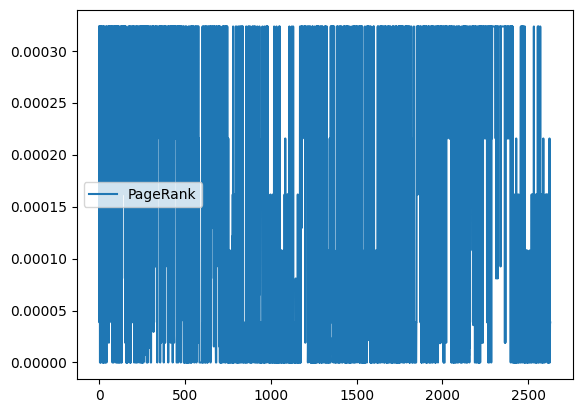

In [27]:
import matplotlib.pyplot as plt
page_ranks_values = [v.toarray()[0][0] for v in page_ranks]
plt.plot(range(n), page_ranks_values, label = "PageRank") 
plt.legend() 
plt.show()
#nothing


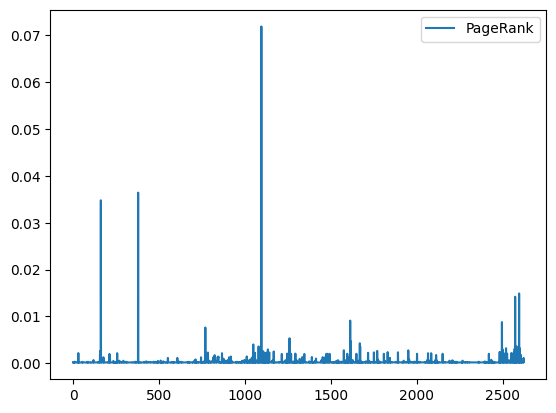

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(n), v, label = "PageRank") 
plt.legend() 
plt.show()